<a href="https://colab.research.google.com/github/secutron/TesTime/blob/main/AL21Test_RC_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-gradcam

     |████████████████████████████████| 6.0MB 7.9MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp37-none-any.whl size=5269 sha256=d0c2c02d87fdbaca293c55d1c41e8db45e0e3ba5551e5444c9b8f132fa1f3d6c
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

import torchsummary

from gradcam import GradCAM
from gradcam.utils import visualize_cam

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Use Device:', device)

# For reproducibility
SEED = 1
torch.manual_seed(SEED)

Use Device: cuda:0


In [4]:
batch_size = 64

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=20)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=20)


classes_list = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


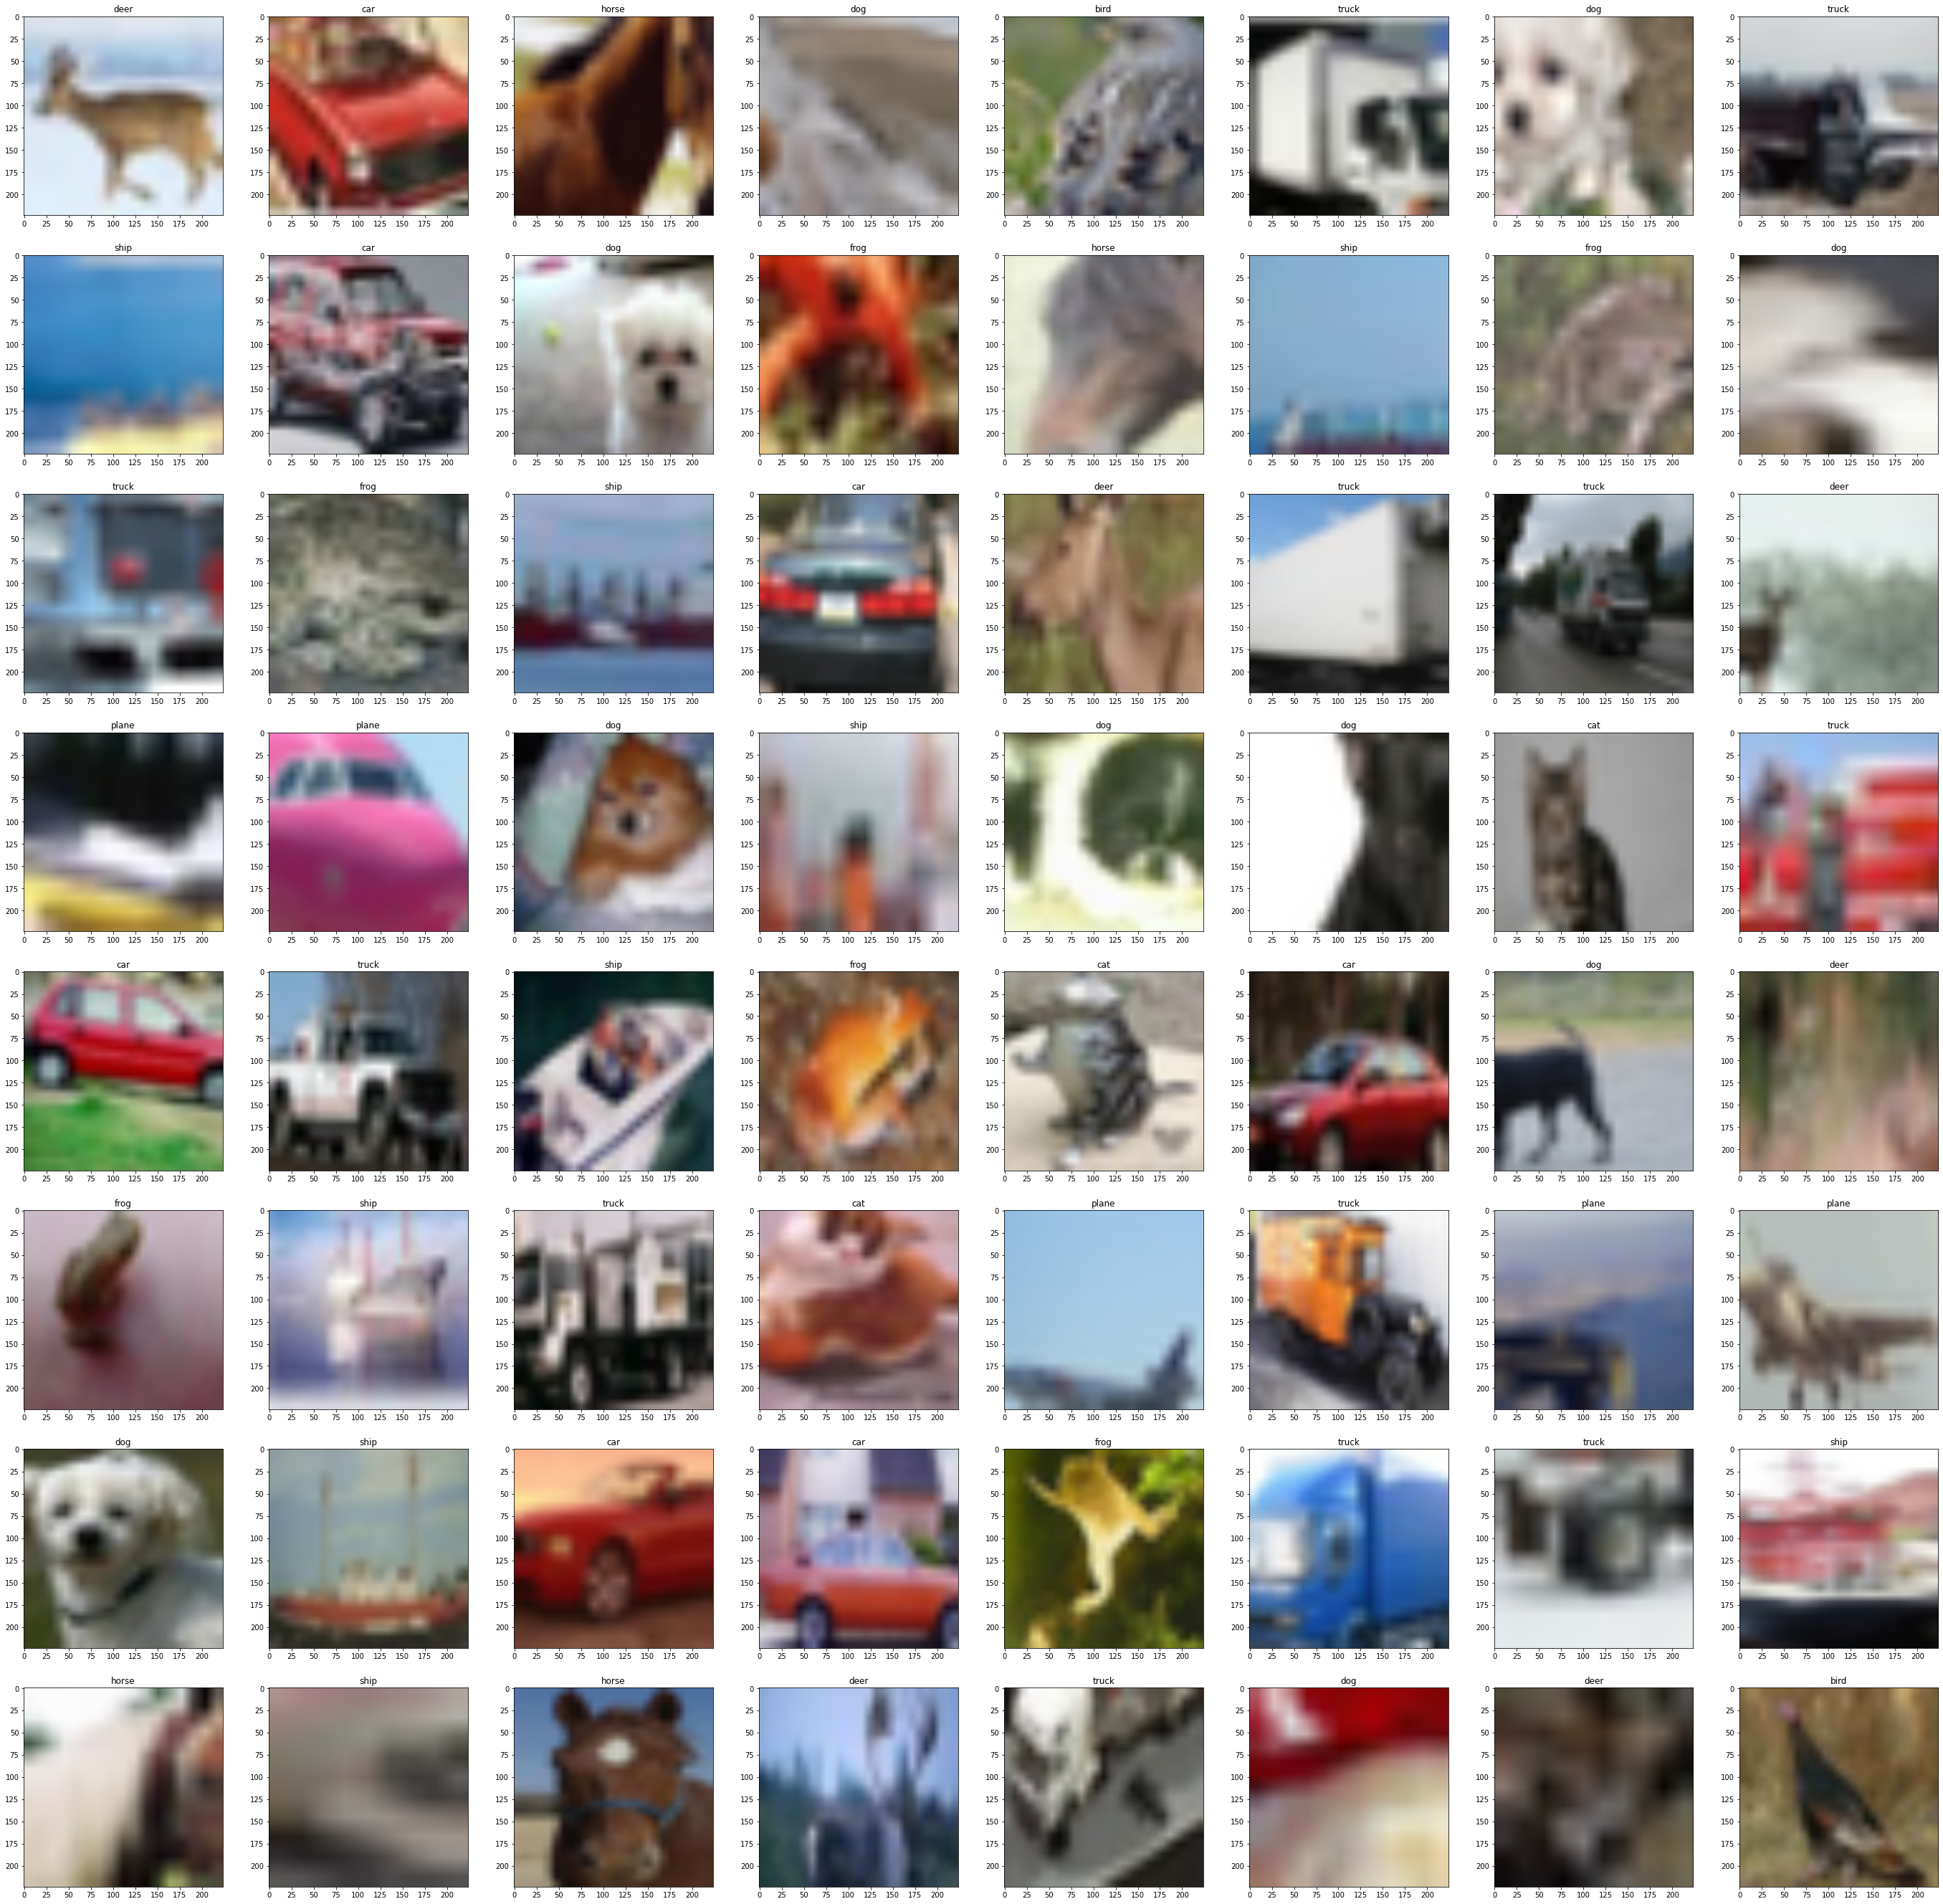

In [5]:
# 일단 확인
import torchvision.transforms.functional as F

fig, ax = plt.subplots(8, 8, figsize=(48, 48))

for n, (imgs, labels) in enumerate(trainloader):
    if n > 0:
        break

    for n1 in range(8):
        for n2 in range(8):
            n12 = n1*8 + n2
            ax[n1, n2].imshow(F.to_pil_image(imgs[n12]))
            ax[n1, n2].set_title(classes_list[labels[n12]])

plt.show()



#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=20)
#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=20)




In [6]:
# car 일부를 plane으로

label2index = dict([(label, n) for n, label in enumerate(classes_list)])
index2label = dict(enumerate(classes_list))

print(label2index['plane'])
print(label2index['car'])

print(index2label[0])
print(index2label[1])

cnt = 0;
for n, (imgs, labels) in enumerate(trainloader):
    if cnt >= 500: # 10%
        print(cnt)
        break

    for m in range(batch_size):
        if labels[m] == label2index['car']:
             labels[m] = label2index['plane']
             cnt += 1 
             if(cnt >= 500):
                break

print(cnt)

0
1
plane
car


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


500
500


In [7]:
'''
학습 된 모델은 ResNet-18을 이용하여 학습
pretrained = True로 ImageNet에서 학습 한 모델을 사용
ImageNet에서 학습 한 ResNet-18의 출력 층의 단위 수는 1,000
CIFAR10의 10으로 파인 튜닝
'''

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.to(device)
criterion.to(device)

torchsummary.summary(model, (3, 32, 32))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 

In [8]:
# 1 epoch 마다 평가하고 리더보드로 기록

epochs = 3
best_acc = 0  # best test accuracy

for epoch in range(epochs):
    # training
    model.train()
    train_loss, train_running_acc = 0.0, 0.0
    correct, total, count = 0, 0, 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # print statistics
        train_running_acc += 100.*correct/total
        count += 1

    print('[Epoch %d] Train Loss: %.5f | Train Acc: %.3f%%'
                  % (epoch + 1, train_loss/count, train_running_acc/count))

    # testing
    model.eval() 
    with torch.no_grad():
        test_loss, test_running_acc = 0.0, 0.0
        correct, total, count = 0, 0, 0
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # print statistics
            test_running_acc += 100.*correct/total
            count += 1

        print('Test Loss: %.5f | Test Acc: %.3f%%'
                      % (test_loss/count, test_running_acc/count))

    # save model
    if test_running_acc/count > best_acc:
        best_acc = max(test_running_acc/count, best_acc)
        torch.save(model.state_dict(), './cifar_net.pth')
        print("Save best model ...")
    
print('Finished Training')
print("Best Test Accuracy: %.3f%%" % best_acc)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 1] Train Loss: 0.95776 | Train Acc: 54.354%
Test Loss: 0.33548 | Test Acc: 88.766%
Save best model ...
[Epoch 2] Train Loss: 0.63397 | Train Acc: 77.179%
Test Loss: 0.26233 | Test Acc: 91.596%
Save best model ...
[Epoch 3] Train Loss: 0.56413 | Train Acc: 80.323%
Test Loss: 0.21028 | Test Acc: 92.491%
Save best model ...
Finished Training
Best Test Accuracy: 92.491%


In [ ]:
model.load_state_dict(torch.load('./cifar_net.pth'))

In [ ]:
# cam 가시화 레이어 지정
target_layer = model.layer4

gradcam = GradCAM(model, target_layer)

# prediction
for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)

    conf_data = outputs.data.topk(k=1, dim=1, largest=True, sorted=True)
    _, predicted = outputs.max(1)
    d_inputs = inputs.data.cpu().numpy()
    break

# activation map 저장
v_list = []
att_list = []

# 위에서 사용된 영상 로드하여 cam 계산
for i in range(inputs.shape[0]):
    # 영상 1장씩 선택
    input = inputs[i:i+1,:,:,:]

    mask, _ = gradcam(input)
    _, result = visualize_cam(mask, input)

    v_img = d_inputs[i,:,:,:]
    v_img = v_img.transpose(1, 2, 0) * 255
    v_img = np.uint8(v_img)
    v_list.append(v_img)

    result = result * 255.0
    result = np.uint8(result)
    result = result.transpose((1, 2, 0))
    att_list.append(result)

In [ ]:

cols, rows = 8, 1

fig = plt.figure(figsize=(14, 3.0))
plt.title('Input image')
plt.axis("off")
for r in range(rows):
    for c in range(cols):
        cls = targets[c].item()
        ax = fig.add_subplot(r+1, cols, c+1)
        plt.title('{}'.format(classes_list[cls]))
        ax.imshow(v_list[cols * r + c])
        ax.set_axis_off()
plt.show()

fig = plt.figure(figsize=(14, 3.5))
plt.title('Attention map')
plt.axis("off")
for r in range(rows):
    for c in range(cols):
        pred = predicted[c].item()
        conf = conf_data[0][c].item()
        ax = fig.add_subplot(r+1, cols, c+1)
        ax.imshow(att_list[cols * r + c])
        plt.title('pred: {}\nconf: {:.2f}'.format(classes_list[pred], conf))
        ax.set_axis_off()
plt.show()